# TBD -loading data, sparkSQL, DF API


## Wczytanie danych

Bedziemy wykorzystywać dane z ankiety StackOverflow z 2020.

https://insights.stackoverflow.com/survey/

Dane sa dostepne na google drive. Skorzystamy z modułu GoogleDriveDownloader, ktory pozwala pobrac dokument o podanym id.


In [1]:
pip install googledrivedownloader

Note: you may need to restart the kernel to use updated packages.


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
from pathlib import Path
path_dir = str(Path.home()) + "/data/2020/"  # ustawmy sciezke na HOME/data/2020
archive_dir = path_dir + "survey.zip"        # plik zapiszemy pod nazwa survey.zip

In [4]:
path_dir

'/home/jovyan/data/2020/'

In [5]:
archive_dir

'/home/jovyan/data/2020/survey.zip'

In [6]:
# sciagniecie pliku we wskazane miejsce
gdd.download_file_from_google_drive(file_id='1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB',
                                    dest_path=archive_dir,
                                    unzip=True)

Unzipping...Done.


##  Podłączenie do sesji Spark


#### WAZNE
jesli w poprzednim notatniku masz aktywną sesję Spark zakończ ją (w poprzednim notatniku) poleceniem spark.stop()

In [7]:
from pyspark.sql import SparkSession
#spark.stop()
spark = SparkSession \
.builder \
.config("spark.executor.instances", "1")\
.config('spark.driver.memory','1g')\
.config('spark.executor.memory', '1g') \
.getOrCreate()

## Dostęp do danych

In [8]:
import os
user_name = 'jovyan'
print(user_name)

jovyan


In [9]:
# ścieżka dostępu do pliku
csv_path = 'file:////home/jovyan/data/2020/survey_results_public.csv'

In [10]:
csv_path

'file:////home/jovyan/data/2020/survey_results_public.csv'

## Spark SQL

Platforma Apache Spark posiada komponent Spark SQL, który pozwala traktować dane jak tabele w bazie danych. Można zakładać swoje schematy baz danych oraz korzystać z języka SQL.

In [11]:
table_name = "survey_2020"                               # nazwa tabeli ktora bedziemy chcieli stworzyc

In [12]:
spark.sql(f'DROP TABLE IF EXISTS {table_name}')       # usun te tabele jesli istniala wczesniej 

# stworz tabele korzystajac z danych we wskazanej lokalizacji
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{csv_path}"')

DataFrame[]

## Weryfikacja danych 
Sprawdzmy zaczytane dane.

In [13]:
spark.sql(f"describe {table_name}").show(100, truncate=False) # niepoprawne typy danych... "NA" 

+----------------------------+---------+-------+
|col_name                    |data_type|comment|
+----------------------------+---------+-------+
|Respondent                  |int      |null   |
|MainBranch                  |string   |null   |
|Hobbyist                    |string   |null   |
|Age                         |double   |null   |
|Age1stCode                  |string   |null   |
|CompFreq                    |string   |null   |
|CompTotal                   |double   |null   |
|ConvertedComp               |double   |null   |
|Country                     |string   |null   |
|CurrencyDesc                |string   |null   |
|CurrencySymbol              |string   |null   |
|DatabaseDesireNextYear      |string   |null   |
|DatabaseWorkedWith          |string   |null   |
|DevType                     |string   |null   |
|EdLevel                     |string   |null   |
|Employment                  |string   |null   |
|Ethnicity                   |string   |null   |
|Gender             

In [14]:
# sprawdzenie liczności tabeli
spark.sql(f"select count(*) from {table_name}").show()

+--------+
|count(1)|
+--------+
|   64461|
+--------+



## Podgląd danych

## Dataframe spark vs pandas

Moduł Pandas jest biblioteką Pythonową do manipulacji danymi. W szczegolnosci w pandas mozemy stworzyc ramki danych i wykonywac na niej analize, agregacje oraz wizualizacje danych. 
Przy nieduzych zbiorach danych i prostych operacjach to doskonała biblioteka. Jednak kiedy zbior danych sie rozrasta lub kiedy wymagane sa zlozone transformacje to operacje moga byc wolne.

Operacje na rozproszonych danych sa szybsze. Ale tu takze napotykamy ograniczenia np trudność w wizualizacji danych.

In [15]:
import pandas as pd

In [16]:
spark.sql(f"select * from {table_name} limit 10").toPandas()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,None,NaN,NaN,United Kingdom,Pound sterling,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,None,NaN,NaN,Russian Federation,None,...,Neither easy nor difficult,Appropriate in length,None,None,None,None,Somewhat more welcome now than last year,NaN,4,None
3,4,I am a developer by profession,Yes,25.0,18,None,NaN,NaN,Albania,Albanian lek,...,None,None,No,"Computer science, computer engineering, or sof...",None,None,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,None,NaN,NaN,United States,None,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8
5,6,I am a developer by profession,No,NaN,14,None,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,None,None,React.js,None,None,NaN,6,4
6,7,I am a developer by profession,Yes,NaN,18,Monthly,NaN,NaN,India,United States dollar,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,A lot more welcome now than last year,NaN,6,4
7,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
8,9,I am a developer by profession,No,30.0,20,None,NaN,NaN,Tunisia,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular.js,jQuery,Just as welcome now as I felt last year,50.0,6,4
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4


**Ważne** 

Metoda toPandas() na ramce pyspark, konwertuje ramkę pyspark do ramki pandas. Wykonuje akcje pobrania (collect) wszystkich danych z executorów (z JVM) i transfer do  programu sterujacego (driver) i konwersje do typu Pythonowego w notatniku. Ze względu na ograniczenia pamięciowe w programie sterującym należy to wykonywać na podzbiorach danych.

**DataFrame.collect() collects the distributed data to the driver side as the local data in Python. Note that this can throw an out-of-memory error when the dataset is too large to fit in the driver side because it collects all the data from executors to the driver side.**

**Note that DataFrame.toPandas() results in the collection of all records in the DataFrame to the driver program and should be done on a small subset of the data.**

In [17]:
dist_df = spark.sql(f"select * from {table_name} LIMIT 10")
local_df = spark.sql(f"select * from {table_name} LIMIT 10").toPandas()

In [18]:
type(dist_df)  # dataframe Sparkowy ("przepis na dane, rozproszony, leniwy")

pyspark.sql.dataframe.DataFrame

In [19]:
type(local_df)  # dataframe Pandasowy (lokalny, sciągnięty do pamięci operacyjnej)

pandas.core.frame.DataFrame

In [20]:
#dist_df.show()

In [21]:
local_df

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,None,NaN,NaN,United Kingdom,Pound sterling,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,None,NaN,NaN,Russian Federation,None,...,Neither easy nor difficult,Appropriate in length,None,None,None,None,Somewhat more welcome now than last year,NaN,4,None
3,4,I am a developer by profession,Yes,25.0,18,None,NaN,NaN,Albania,Albanian lek,...,None,None,No,"Computer science, computer engineering, or sof...",None,None,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,None,NaN,NaN,United States,None,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8
5,6,I am a developer by profession,No,NaN,14,None,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,None,None,React.js,None,None,NaN,6,4
6,7,I am a developer by profession,Yes,NaN,18,Monthly,NaN,NaN,India,United States dollar,...,None,None,None,"Computer science, computer engineering, or sof...",None,None,A lot more welcome now than last year,NaN,6,4
7,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13
8,9,I am a developer by profession,No,30.0,20,None,NaN,NaN,Tunisia,United States dollar,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",Angular.js,jQuery,Just as welcome now as I felt last year,50.0,6,4
9,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4


In [22]:
pd.set_option('display.max_columns', None)    # pokazuj wszystkie kolumny
#pd.reset_option('max_columns')

## Przykład wykorzystania Spark'a do wizualizacji
### Narysuj histogram wieku respondentów

In [23]:
# przygotowanie danych
# przycinamy dane tylko do zakresu ktory jest potrzebny do realizacji polecenia
ages = spark.sql(f"SELECT CAST (Age AS INT) \
                    FROM {table_name} \
                    WHERE age IS NOT NULL \
                    AND age BETWEEN 10 AND 80").toPandas()

In [24]:
ages

,Age
0,25
1,31
2,36
3,30
4,22
...,...
45403,22
45404,34
45405,38
45406,64


array([[<AxesSubplot: title={'center': 'Age'}>]], dtype=object)

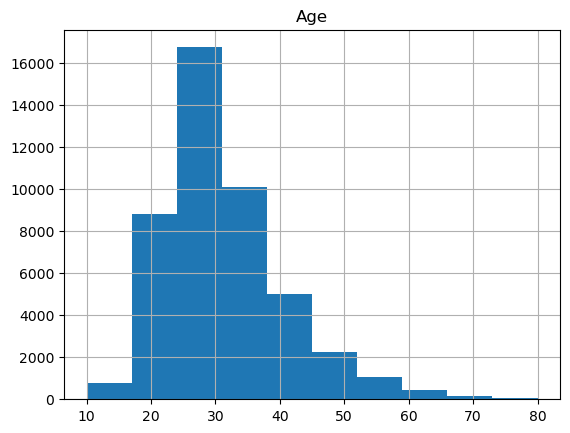

In [25]:
ages.hist("Age", bins=10)
# plt.show()

## Spark DF API

In [26]:
df = spark.read.csv(csv_path, inferSchema=True, header="true", nullValue='NA', nanValue='NA',emptyValue='NA')

In [27]:
type (df)                 # jaki jest typ danych

pyspark.sql.dataframe.DataFrame

In [28]:
df.describe()

DataFrame[summary: string, Respondent: string, MainBranch: string, Hobbyist: string, Age: string, Age1stCode: string, CompFreq: string, CompTotal: string, ConvertedComp: string, Country: string, CurrencyDesc: string, CurrencySymbol: string, DatabaseDesireNextYear: string, DatabaseWorkedWith: string, DevType: string, EdLevel: string, Employment: string, Ethnicity: string, Gender: string, JobFactors: string, JobSat: string, JobSeek: string, LanguageDesireNextYear: string, LanguageWorkedWith: string, MiscTechDesireNextYear: string, MiscTechWorkedWith: string, NEWCollabToolsDesireNextYear: string, NEWCollabToolsWorkedWith: string, NEWDevOps: string, NEWDevOpsImpt: string, NEWEdImpt: string, NEWJobHunt: string, NEWJobHuntResearch: string, NEWLearn: string, NEWOffTopic: string, NEWOnboardGood: string, NEWOtherComms: string, NEWOvertime: string, NEWPurchaseResearch: string, NEWPurpleLink: string, NEWSOSites: string, NEWStuck: string, OpSys: string, OrgSize: string, PlatformDesireNextYear: str

In [29]:
df.explain()              # fizyczny plan wykonania

== Physical Plan ==
FileScan csv [Respondent#494,MainBranch#495,Hobbyist#496,Age#497,Age1stCode#498,CompFreq#499,CompTotal#500,ConvertedComp#501,Country#502,CurrencyDesc#503,CurrencySymbol#504,DatabaseDesireNextYear#505,DatabaseWorkedWith#506,DevType#507,EdLevel#508,Employment#509,Ethnicity#510,Gender#511,JobFactors#512,JobSat#513,JobSeek#514,LanguageDesireNextYear#515,LanguageWorkedWith#516,MiscTechDesireNextYear#517,... 37 more fields] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/jovyan/data/2020/survey_results_public.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Respondent:int,MainBranch:string,Hobbyist:string,Age:double,Age1stCode:string,CompFreq:str...




In [30]:
df.explain(True)          # logiczny i fizyczny plan wykonania

== Parsed Logical Plan ==
Relation [Respondent#494,MainBranch#495,Hobbyist#496,Age#497,Age1stCode#498,CompFreq#499,CompTotal#500,ConvertedComp#501,Country#502,CurrencyDesc#503,CurrencySymbol#504,DatabaseDesireNextYear#505,DatabaseWorkedWith#506,DevType#507,EdLevel#508,Employment#509,Ethnicity#510,Gender#511,JobFactors#512,JobSat#513,JobSeek#514,LanguageDesireNextYear#515,LanguageWorkedWith#516,MiscTechDesireNextYear#517,... 37 more fields] csv

== Analyzed Logical Plan ==
Respondent: int, MainBranch: string, Hobbyist: string, Age: double, Age1stCode: string, CompFreq: string, CompTotal: double, ConvertedComp: double, Country: string, CurrencyDesc: string, CurrencySymbol: string, DatabaseDesireNextYear: string, DatabaseWorkedWith: string, DevType: string, EdLevel: string, Employment: string, Ethnicity: string, Gender: string, JobFactors: string, JobSat: string, JobSeek: string, LanguageDesireNextYear: string, LanguageWorkedWith: string, MiscTechDesireNextYear: string, ... 37 more fields

In [31]:
df.rdd.getNumPartitions() # liczba partycji (bloków danych)

4

In [32]:
df.printSchema()          # schemat danych

root
 |-- Respondent: integer (nullable = true)
 |-- MainBranch: string (nullable = true)
 |-- Hobbyist: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Age1stCode: string (nullable = true)
 |-- CompFreq: string (nullable = true)
 |-- CompTotal: double (nullable = true)
 |-- ConvertedComp: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- CurrencyDesc: string (nullable = true)
 |-- CurrencySymbol: string (nullable = true)
 |-- DatabaseDesireNextYear: string (nullable = true)
 |-- DatabaseWorkedWith: string (nullable = true)
 |-- DevType: string (nullable = true)
 |-- EdLevel: string (nullable = true)
 |-- Employment: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobFactors: string (nullable = true)
 |-- JobSat: string (nullable = true)
 |-- JobSeek: string (nullable = true)
 |-- LanguageDesireNextYear: string (nullable = true)
 |-- LanguageWorkedWith: string (nullable = true)
 |-- MiscTec

In [33]:
df.count()                # wymiary (liczba wierszy)

64461

In [34]:
len(df.columns)           # wymiary (liczba kolumn)

61

In [35]:
df.describe().show()      # pokaż podsumowanie danych w tabeli

+-------+------------------+--------------------+--------+-----------------+--------------------+--------+--------------------+------------------+-----------+----------------+--------------+----------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+------------------+----------------------+------------------+----------------------------+------------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+-------------+--------------------+--------------------+-------------+--------------------+--------------------+-------+--------------------+----------------------+------------------+--------------------+--------------------+---------+-------------+--------------------+--------------------+--------------------+-----------

In [36]:
df.describe("Age").show() # pokaż podsumowanie danych w kolumnie 

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|            45446|
|   mean|30.83411081283281|
| stddev| 9.58539232884474|
|    min|              1.0|
|    max|            279.0|
+-------+-----------------+



In [37]:
df.show()                 # pokaż 20 wierszy danych 

+----------+--------------------+--------+----+----------+--------+---------+-------------+------------------+--------------------+--------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+----------------------+--------------------+----------------------+--------------------+----------------------------+------------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------------+--------------------+--------------------+-----------------+--------------------+--------------------+-----------+--------------------+----------------------+--------------------+--------------------+--------------------+---------+---------------+--------------------+--------------------+--------------------+--------------------+-----+----------------

In [38]:
df.show(10, truncate=False) # pokaż 10 wierszy, nie skracaj danych

+----------+--------------------------------------------------------+--------+----+----------+--------+---------+-------------+------------------+--------------------+--------------+----------------------+-----------------------------------------+---------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------+----------------------------------------------------+----------------------------+------+------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+------------------------------------------------------------+-------------------------------------+-----------------------------------+--------------------------------+------------------+--------------------------------------+---------------------------------------------------------------------------+---------+--------

In [39]:
df.select("Age").show()  # pokaż tylko jedną kolumne

+----+
| Age|
+----+
|null|
|null|
|null|
|25.0|
|31.0|
|null|
|null|
|36.0|
|30.0|
|22.0|
|23.0|
|49.0|
|53.0|
|27.0|
|null|
|45.0|
|25.0|
|32.0|
|24.0|
|40.0|
+----+
only showing top 20 rows



In [40]:
df.select("Country", "Age", "ConvertedComp").show() # pokaż wybrane kolumny 

+------------------+----+-------------+
|           Country| Age|ConvertedComp|
+------------------+----+-------------+
|           Germany|null|         null|
|    United Kingdom|null|         null|
|Russian Federation|null|         null|
|           Albania|25.0|         null|
|     United States|31.0|         null|
|           Germany|null|         null|
|             India|null|         null|
|     United States|36.0|     116000.0|
|           Tunisia|30.0|         null|
|    United Kingdom|22.0|      32315.0|
|    United Kingdom|23.0|      40070.0|
|             Spain|49.0|      14268.0|
|       Netherlands|53.0|      38916.0|
|     United States|27.0|      66000.0|
|            France|null|         null|
|    United Kingdom|45.0|     108576.0|
|     United States|25.0|      79000.0|
|     United States|32.0|    1260000.0|
|     United States|24.0|      83400.0|
|             Spain|40.0|         null|
+------------------+----+-------------+
only showing top 20 rows



In [41]:
df_country = df.select(df.Country).distinct() # stworz nowy DF zawierajacy tylko unikalne wartosci nazw krajow

In [42]:
df_country.count()

184

In [43]:
df.filter("Country = 'Spain'")

DataFrame[Respondent: int, MainBranch: string, Hobbyist: string, Age: double, Age1stCode: string, CompFreq: string, CompTotal: double, ConvertedComp: double, Country: string, CurrencyDesc: string, CurrencySymbol: string, DatabaseDesireNextYear: string, DatabaseWorkedWith: string, DevType: string, EdLevel: string, Employment: string, Ethnicity: string, Gender: string, JobFactors: string, JobSat: string, JobSeek: string, LanguageDesireNextYear: string, LanguageWorkedWith: string, MiscTechDesireNextYear: string, MiscTechWorkedWith: string, NEWCollabToolsDesireNextYear: string, NEWCollabToolsWorkedWith: string, NEWDevOps: string, NEWDevOpsImpt: string, NEWEdImpt: string, NEWJobHunt: string, NEWJobHuntResearch: string, NEWLearn: string, NEWOffTopic: string, NEWOnboardGood: string, NEWOtherComms: string, NEWOvertime: string, NEWPurchaseResearch: string, NEWPurpleLink: string, NEWSOSites: string, NEWStuck: string, OpSys: string, OrgSize: string, PlatformDesireNextYear: string, PlatformWorkedW

In [44]:
df.filter("Country = 'Spain' and Age > 50" ).toPandas()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,2914,I am a developer by profession,No,57.0,17,Yearly,57000.0,61616.0,Spain,European Euro,EUR,MongoDB,Microsoft SQL Server,"Developer, back-end;Developer, desktop or ente...","Secondary school (e.g. American high school, G...",Employed full-time,Hispanic or Latino/a/x,Man,Industry that I’d be working in;Flex time or a...,Slightly dissatisfied,I am not interested in new job opportunities,None,C#;SQL,None,.NET,None,Github;Microsoft Teams,No,Somewhat important,Very important,Curious about other opportunities;Better compe...,None,Once a decade,Not sure,Yes,Yes,Often: 1-2 days per week or more,Ask developers I know/work with;Visit develope...,Indifferent,Stack Overflow (public Q&A for anyone who code...,Call a coworker or friend;Visit Stack Overflow...,Windows,100 to 499 employees,None,Windows,I have a great deal of influence,Straight / Heterosexual,Yes,"Yes, definitely",Multiple times per day,Daily or almost daily,Easy,Too long,No,None,None,ASP.NET,Somewhat less welcome now than last year,50.0,40,32
1,4466,I am a developer by profession,Yes,59.0,15,None,NaN,NaN,Spain,European Euro,EUR,MongoDB;MySQL;PostgreSQL,Microsoft SQL Server;MongoDB;MySQL;PostgreSQL,Data scientist or machine learning specialist;...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed full-time,White or of European descent,Man,"Languages, frameworks, and other technologies ...",Very satisfied,I am not interested in new job opportunities,Bash/Shell/PowerShell,Bash/Shell/PowerShell;HTML/CSS;Java;Python;SQL,None,None,"Github;Slack;Google Suite (Docs, Meet, etc)","Github;Slack;Google Suite (Docs, Meet, etc)",Yes,Extremely important,Very important,Better compensation;Wanting to work with new t...,Personal network - friends or family,Once every few years,No,Yes,No,Sometimes: 1-2 days per month but less than we...,None,"Hello, old friend",Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,20 to 99 employees,Linux;MacOS,Linux;MacOS,I have little or no influence,Straight / Heterosexual,Yes,"Yes, definitely",A few times per week,Multiple times per day,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",None,Django,Just as welcome now as I felt last year,40.0,30,25
2,8472,I am a developer by profession,No,53.0,16,Yearly,50000.0,54049.0,Spain,European Euro,EUR,Microsoft SQL Server;PostgreSQL,Elasticsearch;Microsoft SQL Server;SQLite,"Developer, desktop or enterprise applications;...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,Remote work options;Opportunities for professi...,Very satisfied,I am not interested in new job opportunities,Python;SQL,SQL,None,None,Confluence;Jira;Github;Slack;Microsoft Teams;T...,Confluence;Jira;Github;Slack;Microsoft Teams;T...,No,Neutral,Very important,None,Company reviews from third party sites (e.g. G...,Once every few years,Yes,Onboarding? What onboarding?,Yes,Often: 1-2 days per week or more,Start a free trial,Indifferent,Stack Overflow (public Q&A for anyone who codes),Call a coworker or friend;Visit Stack Overflow,Windows,2 to 9 employees,Android;Microsoft Azure;Windows,An

### Grupowanie i funkcje agregujące

In [45]:
from pyspark.sql.functions import *
df.groupBy("Country").count().show()   # dokonaj grupowania po Country i zlicz liczbe respondentow

+--------------------+-----+
|             Country|count|
+--------------------+-----+
|       Côte d'Ivoire|   17|
|            Paraguay|   26|
|The former Yugosl...|   38|
|               Yemen|    7|
|             Senegal|   26|
|              Sweden|  886|
|  Hong Kong (S.A.R.)|  111|
|   Republic of Korea|   88|
|         Philippines|  405|
|             Eritrea|    3|
|           Singapore|  228|
|            Malaysia|  231|
|              Turkey|  777|
|              Malawi|    8|
|                Iraq|   44|
|             Germany| 3890|
|         Afghanistan|   84|
|            Cambodia|   31|
|              Jordan|   57|
|            Maldives|   10|
+--------------------+-----+
only showing top 20 rows



In [46]:
df.groupBy("Country").avg("Age").show() # dokonaj grupowania po Contry i policz sredni wiek

+--------------------+------------------+
|             Country|          avg(Age)|
+--------------------+------------------+
|       Côte d'Ivoire|25.666666666666668|
|            Paraguay|           27.5625|
|The former Yugosl...| 28.77777777777778|
|               Yemen|              31.0|
|             Senegal|29.444444444444443|
|              Sweden| 33.77761836441894|
|  Hong Kong (S.A.R.)| 29.78030303030303|
|   Republic of Korea|30.434782608695652|
|         Philippines|  25.7803738317757|
|             Eritrea|              31.0|
|           Singapore|28.575949367088608|
|            Malaysia| 28.29787234042553|
|              Turkey|29.477406679764243|
|              Malawi|              26.0|
|                Iraq|24.736842105263158|
|             Germany|30.890311082307193|
|         Afghanistan|23.545454545454547|
|            Cambodia|              27.5|
|              Jordan| 26.91891891891892|
|            Maldives|18.666666666666668|
+--------------------+------------

In [47]:
df.withColumn ("Bonus", col("ConvertedComp") + 1000).filter("ConvertedComp is not NULL").toPandas() # dodaj kolumne

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro,Bonus
0,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,USD,MongoDB,MariaDB;MySQL;Redis,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,White or of European descent,Man,Remote work options;Opportunities for professi...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",JavaScript,Python;SQL,Unity 3D,Ansible,None,Confluence;Jira;Github;Slack;Microsoft Teams;G...,Yes,Extremely important,Not at all important/not necessary,Curious about other opportunities;Better compe...,"Read company media, such as employee blogs or ...",Once a year,Not sure,Yes,No,Occasionally: 1-2 days per quarter but less th...,Start a free trial;Ask developers I know/work ...,"Hello, old friend",Stack Overflow (public Q&A for anyone who code...,Play games;Call a coworker or friend;Visit Sta...,Linux-based,20 to 99 employees,iOS;Slack Apps and Integrations,Docker,I have some influence,Straight / Heterosexual,Yes,"No, not really",Less than once per month or monthly,Multiple times per day,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",Django;React.js;Vue.js,Flask,Just as welcome now as I felt last year,39.0,17,13,117000.0
1,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,GBP,Microsoft SQL Server,Microsoft SQL Server,"Database administrator;Developer, full-stack;D...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed full-time,White or of European descent,Man,Flex time or a flexible schedule;How widely us...,Very satisfied,"I’m not actively looking, but I am open to new...",HTML/CSS;Java;JavaScript;Python;R;SQL,HTML/CSS;Java;JavaScript;Python;SQL,Pandas;TensorFlow,Pandas,Github;Microsoft Teams,Github;Microsoft Teams,No,Neutral,Fairly important,Curious about other opportunities;Better compe...,Company reviews from third party sites (e.g. G...,Every few months,Yes,Onboarding? What onboarding?,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,"Hello, old friend",Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow,Windows,2 to 9 employees,Android;Linux;Raspberry Pi;Windows,Android;Linux;Raspberry Pi;Windows,I have a great deal of influence,Straight / Heterosexual,Yes,"Yes, definitely",Multiple times per day,Multiple times per day,Easy,Appropriate in length,No,Mathematics or statistics,Flask;jQuery,Flask;jQuery,Somewhat more welcome now than last year,36.0,8,4,33315.0
2,11,I am a developer by profession,Yes,23.0,13,Yearly,31000.0,40070.0,United Kingdom,Pound sterling,GBP,Firebase;MongoDB;PostgreSQL,Firebase;MongoDB;PostgreSQL;SQLite,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,White or of European descent,Man,"Flex time or a flexible schedule;Languages, fr...",Slightly dissatisfied,I am actively looking for a job,Go;JavaScript;Swift;TypeScript,C#;JavaScript;Swift,Node.js;React Native,Node.js,"Jira;Github;Slack;Google Suite (Docs, Meet, etc)",Confluence;Jira;Github;Slack;Microsoft Teams;M...,No,Extremely important,Ve

In [48]:
df.drop("Age").show()  # usun kolumne Chromosome. 
# Czy DF została pozbawiona kolumny na trwale?

+----------+--------------------+--------+----------+--------+---------+-------------+------------------+--------------------+--------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+----------------------+--------------------+----------------------+--------------------+----------------------------+------------------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-------------+--------------------+--------------------+-----------------+--------------------+--------------------+-----------+--------------------+----------------------+--------------------+--------------------+--------------------+---------+---------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+

### Zapis wyników

In [49]:
df2 = df.withColumn ("Bonus", col("ConvertedComp") + 1000).filter("ConvertedComp is not NULL")   # dodaj kolumne  i zapisz do nowego DF

In [50]:
output_path = 'file:///home/jovyan/data/out.csv'
df2.write.format("csv").mode("overwrite").save(output_path)

In [51]:
spark.stop()